<a href="https://colab.research.google.com/github/taka7peace/election_analysis.jp/blob/main/election_LightGBM.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
pip install seaborn-analyzer

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 59.7/59.7 kB 2.2 MB/s eta 0:00:00


In [ ]:
pip install scikit-learn==1.1.3

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 30.5/30.5 MB 35.4 MB/s eta 0:00:00
  Attempting uninstall: scikit-learn
    Found existing installation: scikit-learn 1.2.2
    Uninstalling scikit-learn-1.2.2:
      Successfully uninstalled scikit-learn-1.2.2


#Introduction

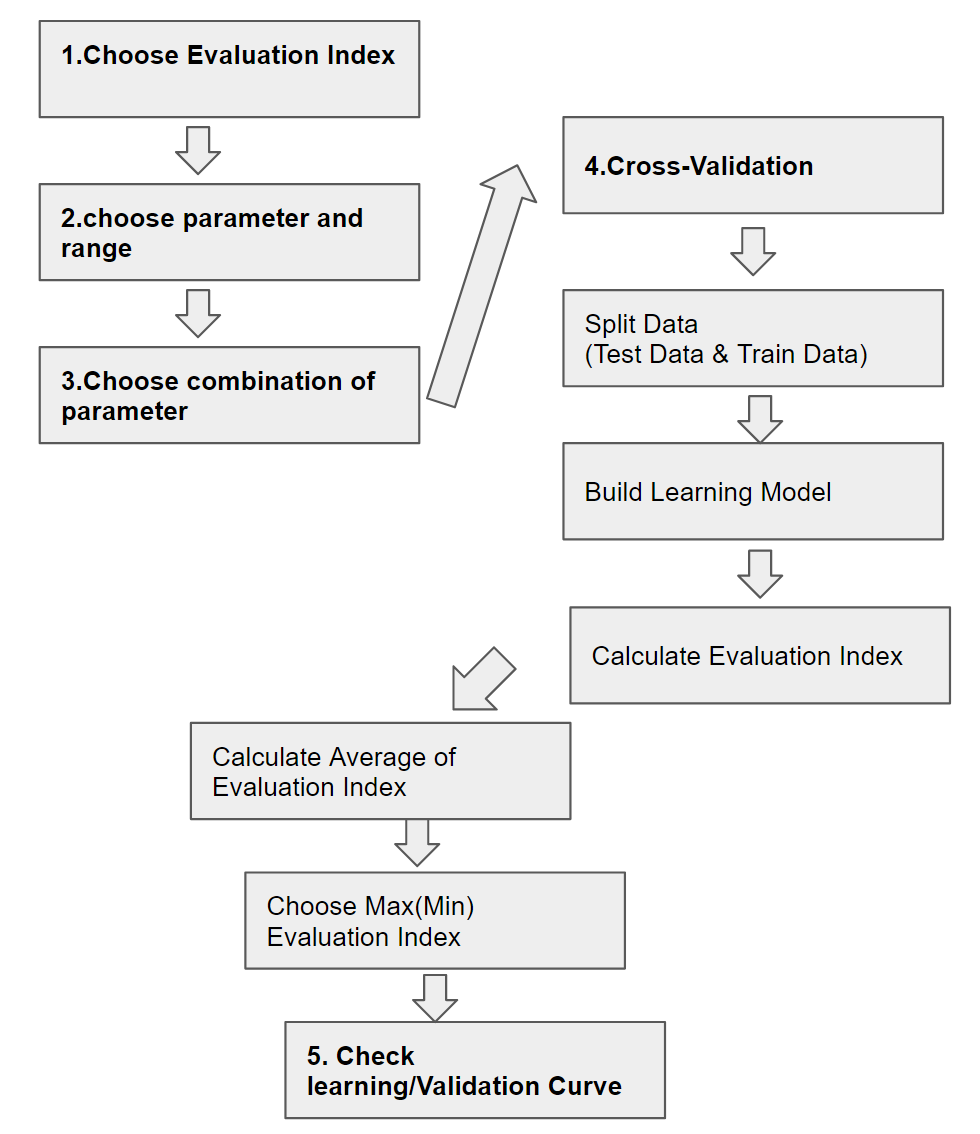

#Data Import
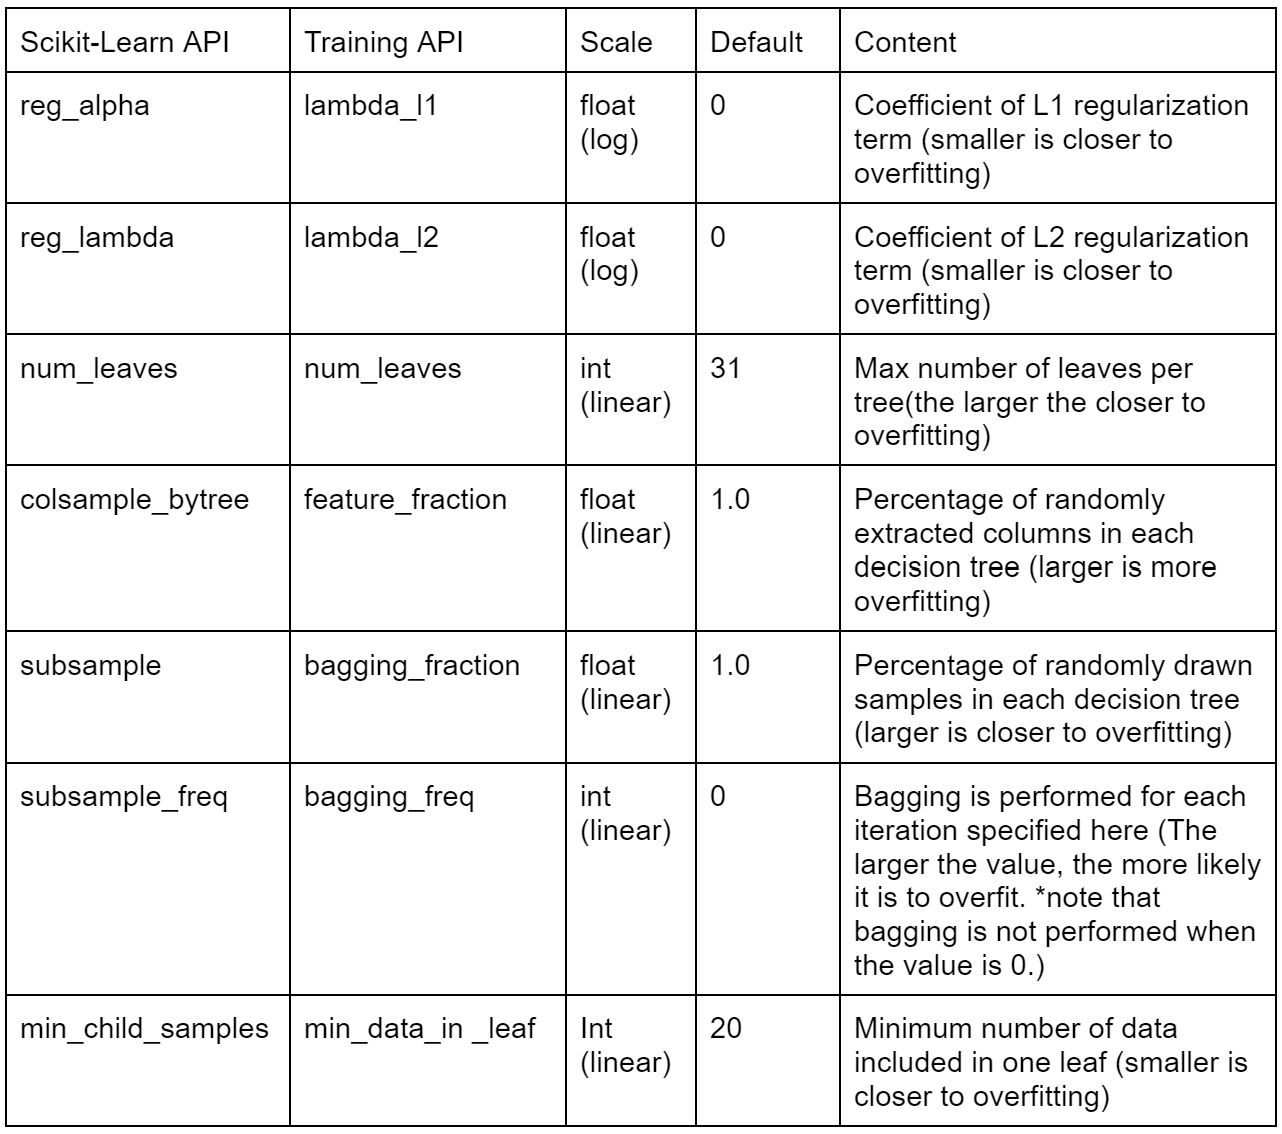

In [ ]:
import pandas as pd
import seaborn as sns

from seaborn_analyzer import classplot
from sklearn.svm import SVC
from sklearn.model_selection import StratifiedKFold
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from seaborn_analyzer import CustomPairPlot
import time



#使用するフィールド
KEY_VALUE = 'ward_before'#キー列
OBJECTIVE_VARIALBLE = 'approval_rate'#目的変数
EXPLANATORY_VALIABLES = ['1_over60','2_between_30to60','3_male_ratio','4_required_time','5_household_member','6_income']#説明変数
USE_EXPLANATORY = ['2_between_30to60','3_male_ratio','5_household_member','latitude']#使用する説明変数
#データ読込
df = pd.read_csv(f'./osaka_metropolis_english.csv')
df
# %%1. pair_analyzerでデータの可視化
use_cols = [OBJECTIVE_VARIALBLE] + EXPLANATORY_VALIABLES
gp = CustomPairPlot()
#gp.pairanalyzer(df[use_cols])
# %%1. pair_analyzerでデータの可視化(特徴量削減後)
use_cols = [OBJECTIVE_VARIALBLE] + USE_EXPLANATORY
#gp.pairanalyzer(df[use_cols])

y = df[OBJECTIVE_VARIALBLE].values  # 目的変数をndarray化
X = df[USE_EXPLANATORY].values  # 説明変数をndarray化

#Checking the model before tuning
Visualize the relationship between the features of the pre-tuning model and the target variable

cv_number=0/3


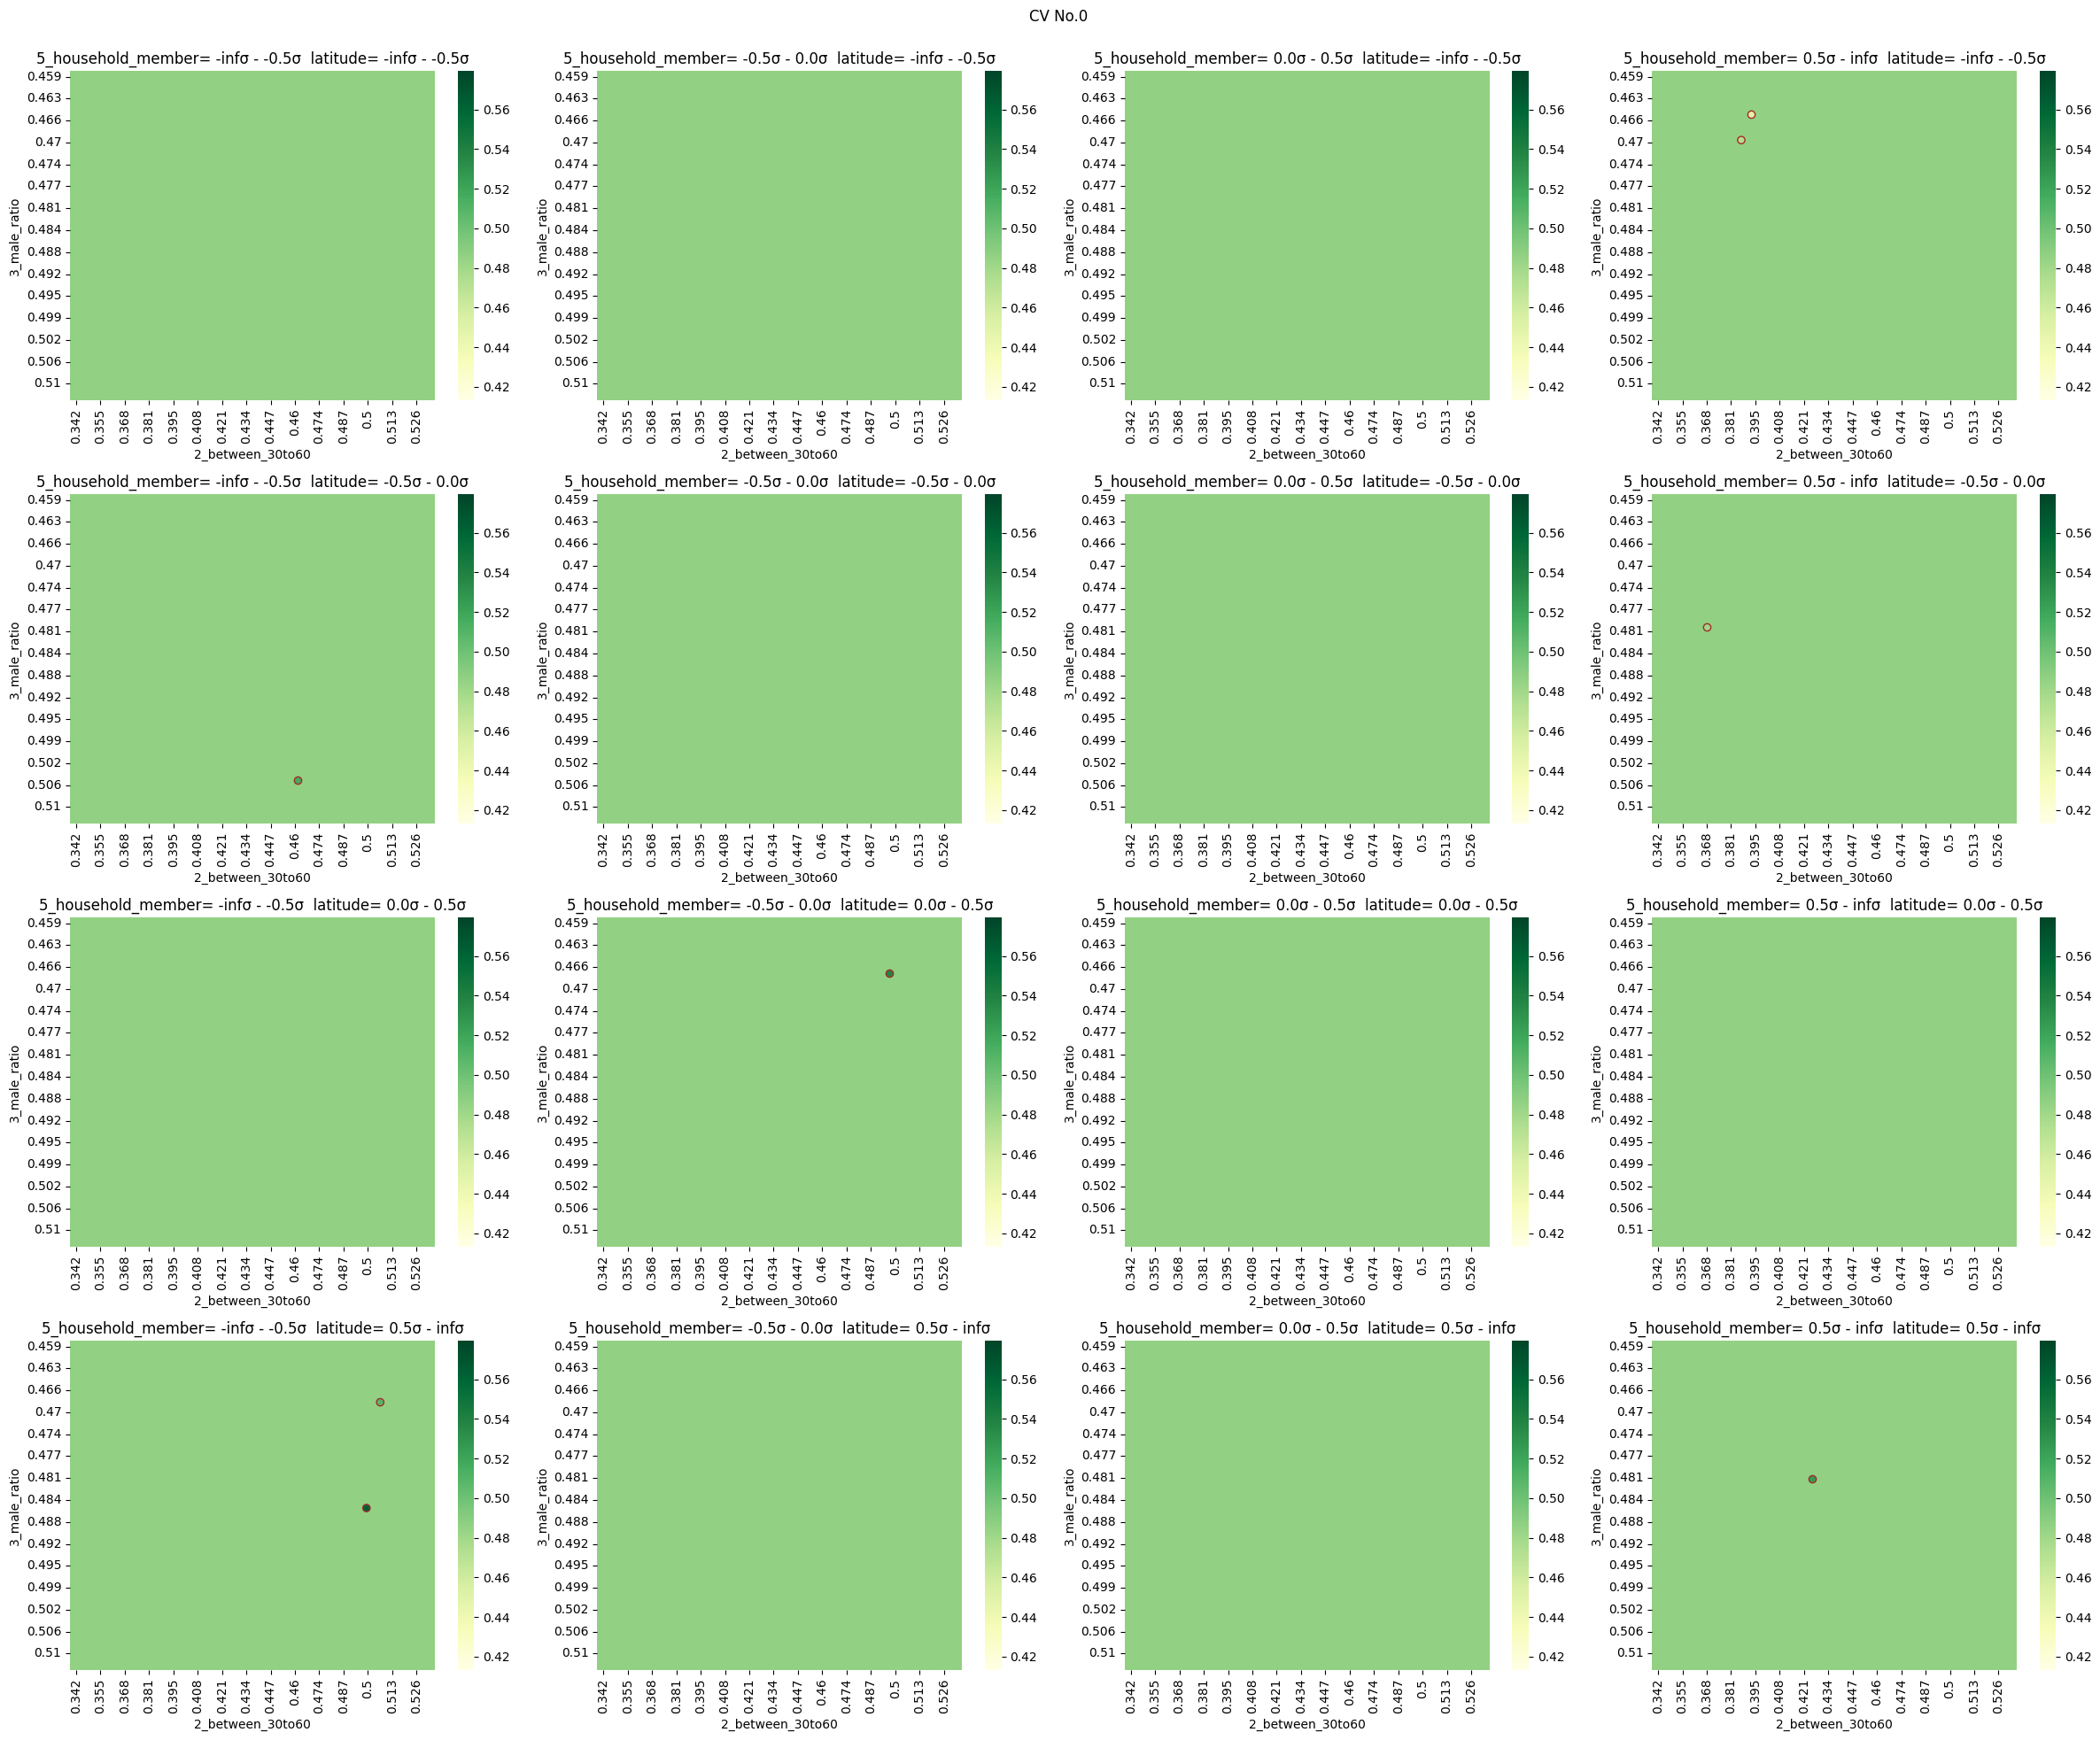

In [ ]:
from lightgbm import early_stopping
from seaborn_analyzer import regplot
from lightgbm import LGBMRegressor
from sklearn.model_selection import KFold

# 乱数シード
seed = 42
# モデル作成
model = LGBMRegressor(boosting_type='gbdt', objective='regression',
                      random_state=seed, n_estimators=10000)  # チューニング前のモデル
# 学習時fitパラメータ指定
fit_params = {'callbacks': [early_stopping(
                  stopping_rounds=10, # 学習時、評価指標がこの回数連続で改善しなくなった時点でストップ
                  verbose=0)],  # 学習中のコマンドライン出力
              'eval_metric': 'rmse',  # early_stopping_roundsの評価指標
              'eval_set': [(X, y)]  # early_stopping_roundsの評価指標算出用データ
              }
# クロスバリデーションして決定境界を可視化
cv = KFold(n_splits=3, shuffle=True, random_state=seed)  # KFoldでクロスバリデーション分割指定
regplot.regression_heat_plot(model, USE_EXPLANATORY, OBJECTIVE_VARIALBLE, df,
                             pair_sigmarange = 0.5, rounddigit_x1=3, rounddigit_x2=3,
                             cv=cv, display_cv_indices=0,
                             fit_params=fit_params)

The predicted value (color intensity) is the same for all conditions, indicating that the regression did not go well.
You can tell at a glance that you need to improve your tuning.

By the way, LGBMRegressor is a class that executes LightGBM regression in the Scikit-Learn API, and is the evaluation index used by objective during learning, and the random number seed used by random_state.

**early_stopping_rounds**

LightGBM has a useful feature called early_stopping_rounds.
XGBoost and LightGBM are algorithms that improve their performance by repeating learning. reference)

early_stopping_rounds is a mechanism for stopping this number of learning times at an appropriate time, and the algorithm is to stop learning when the evaluation index does not improve for ○ times in a row.
Basically, it is better to specify early_stopping_rounds because there is also the learning discontinuation problem described later.

When using early_stopping_rounds with LightGBM of Scikit-Learn API, specify callback, eval_metric and eval_set in dict format for fit_params argument.
You should also specify a large value for n_estimators (eg 10000) so that training is not aborted before reaching the continuous condition.

・Regression

・The data does not contain many outliers

So we adopt RMSE ('neg_root_mean_squared_error' in Scikit-Learn) based on this flow.

Calculate the evaluation index before tuning by cross-validation.

In [ ]:
# %% 手順1) チューニング前の評価指標算出
from sklearn.model_selection import cross_val_score
import numpy as np
scoring = 'neg_root_mean_squared_error'  # 評価指標をMSEに指定
# クロスバリデーションで評価指標算出
scores = cross_val_score(model, X, y, cv=cv,
                         scoring=scoring, n_jobs=-1, fit_params=fit_params)
print(f'scores={scores}')
print(f'average_score={np.mean(scores)}')

scores=[-0.04061413 -0.02937367 -0.04072052]
average_score=-0.03690277287502871


We found the pre-tuning score (neg_mean_squared_error = -MSE) to be -0.001390.
Although it was possible to predict at the time of the visualization mentioned above, the value is quite bad compared to the time of XGBoost.

We will improve this value by tuning

*   type
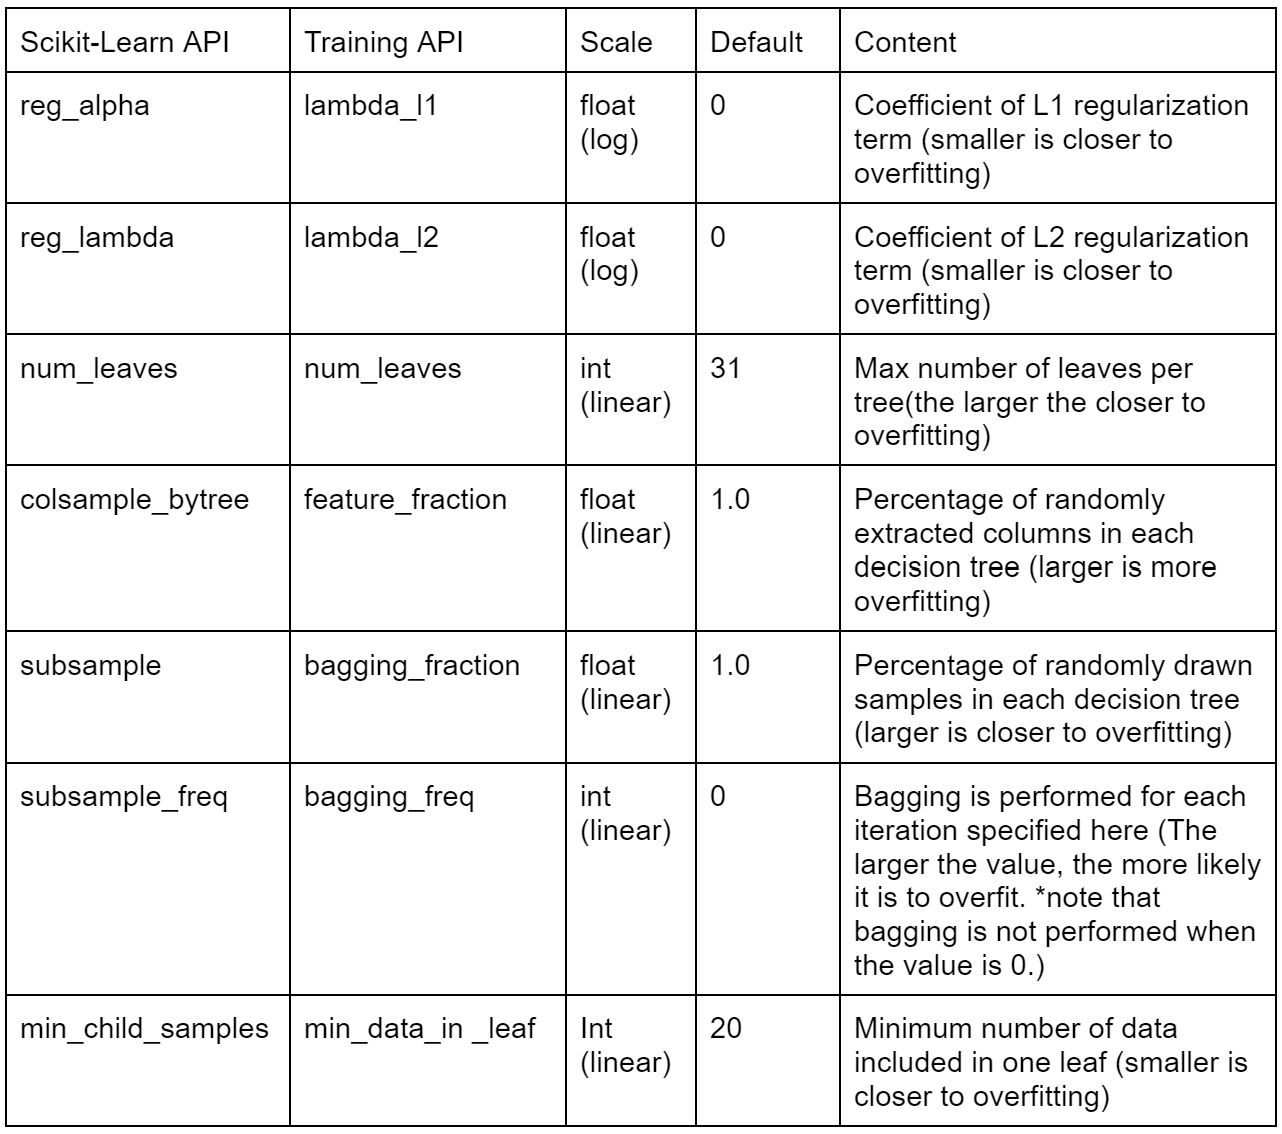
*   range

Set a reasonable initial range, plot the validation curve, and adjust the

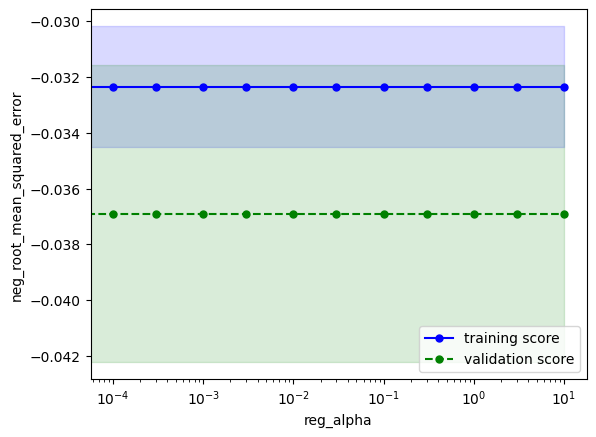

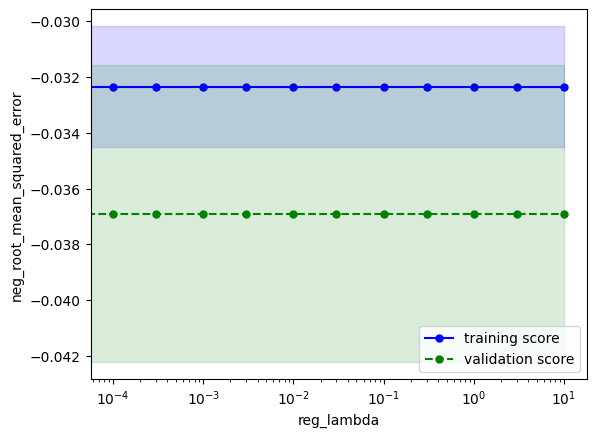

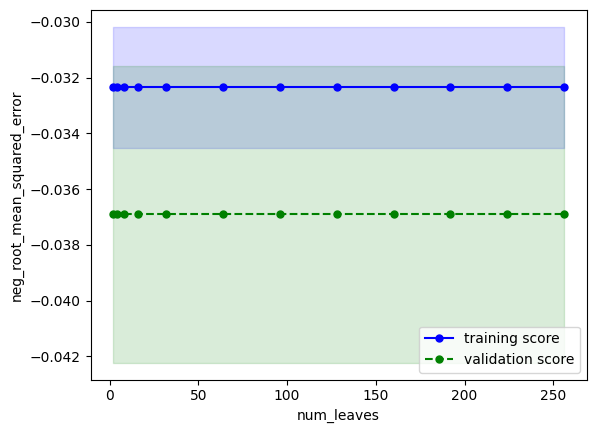

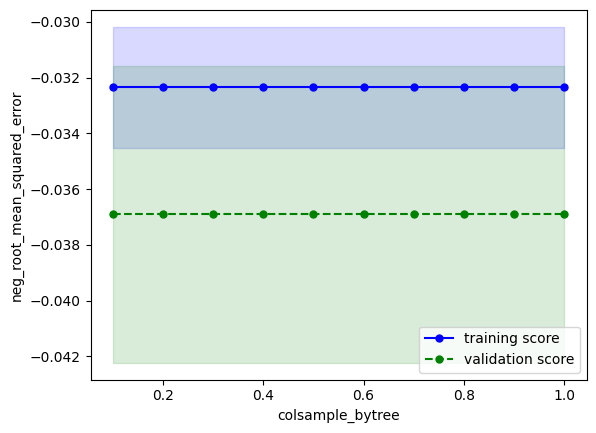

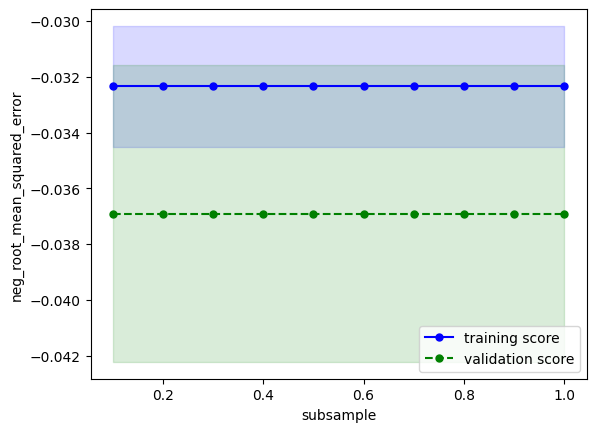

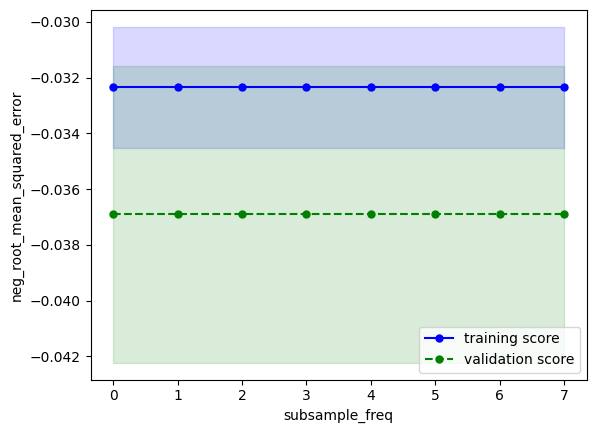

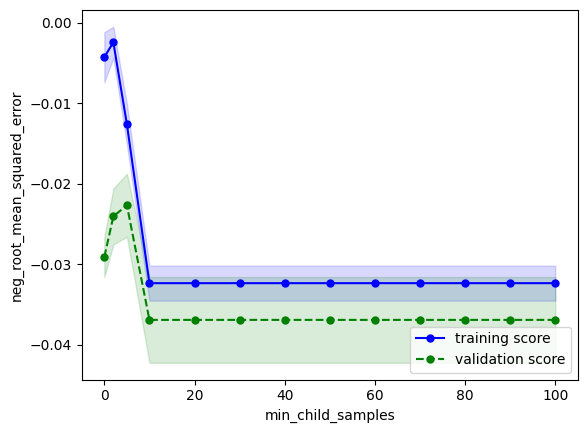

In [ ]:
from sklearn.model_selection import validation_curve
import matplotlib.pyplot as plt
cv_params = {'reg_alpha': [0, 0.0001, 0.0003, 0.001, 0.003, 0.01, 0.03, 0.1, 0.3, 1, 3, 10],
             'reg_lambda': [0, 0.0001, 0.0003, 0.001, 0.003, 0.01, 0.03, 0.1, 0.3, 1, 3, 10],
             'num_leaves': [2, 4, 8, 16, 32, 64, 96, 128, 160, 192, 224, 256],
             'colsample_bytree': [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0],
             'subsample': [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0],
             'subsample_freq': [0, 1, 2, 3, 4, 5, 6, 7],
             'min_child_samples': [0, 2, 5, 10, 20, 30, 40, 50, 60, 70, 80, 90, 100]
             }
param_scales = {'reg_alpha': 'log',
                'reg_lambda': 'log',
                'num_leaves': 'linear',
                'colsample_bytree': 'linear',
                'subsample': 'linear',
                'subsample_freq': 'linear',
                'min_child_samples': 'linear'
                }
# 検証曲線のプロット（パラメータ毎にプロット）
for i, (k, v) in enumerate(cv_params.items()):
    train_scores, valid_scores = validation_curve(estimator=model,
                                                  X=X, y=y,
                                                  param_name=k,
                                                  param_range=v,
                                                  fit_params=fit_params,
                                                  cv=cv, scoring=scoring,
                                                  n_jobs=-1)
    # 学習データに対するスコアの平均±標準偏差を算出
    train_mean = np.mean(train_scores, axis=1)
    train_std  = np.std(train_scores, axis=1)
    train_center = train_mean
    train_high = train_mean + train_std
    train_low = train_mean - train_std
    # テストデータに対するスコアの平均±標準偏差を算出
    valid_mean = np.mean(valid_scores, axis=1)
    valid_std  = np.std(valid_scores, axis=1)
    valid_center = valid_mean
    valid_high = valid_mean + valid_std
    valid_low = valid_mean - valid_std
    # training_scoresをプロット
    plt.plot(v, train_center, color='blue', marker='o', markersize=5, label='training score')
    plt.fill_between(v, train_high, train_low, alpha=0.15, color='blue')
    # validation_scoresをプロット
    plt.plot(v, valid_center, color='green', linestyle='--', marker='o', markersize=5, label='validation score')
    plt.fill_between(v, valid_high, valid_low, alpha=0.15, color='green')
    # スケールをparam_scalesに合わせて変更
    plt.xscale(param_scales[k])
    # 軸ラベルおよび凡例の指定
    plt.xlabel(k)  # パラメータ名を横軸ラベルに
    plt.ylabel(scoring)  # スコア名を縦軸ラベルに
    plt.legend(loc='lower right')  # 凡例
    # グラフを描画
    plt.show()

Most parameters don't change, but only min_child_samples.
This is because the default value of 20 for min_child_samples is too large for 23 samples.

Similarly, the default value of 31 for num_leaves is too large, so

min_child_samples=5

num_leaves=2

and plot the validation curve again.

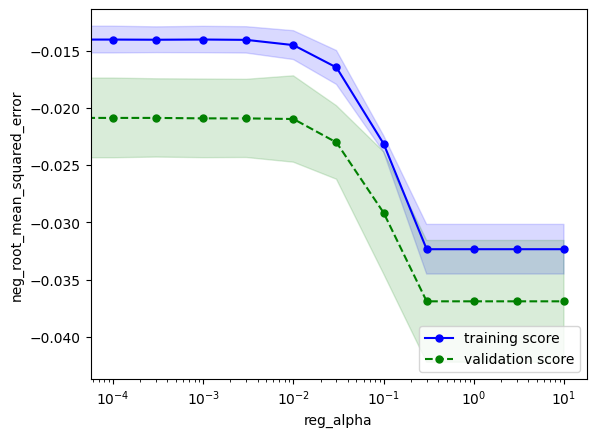

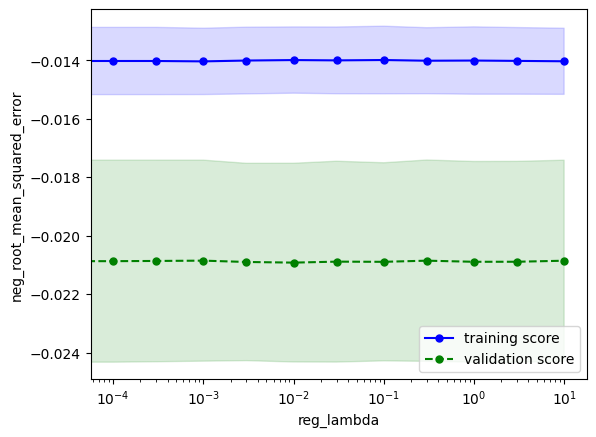

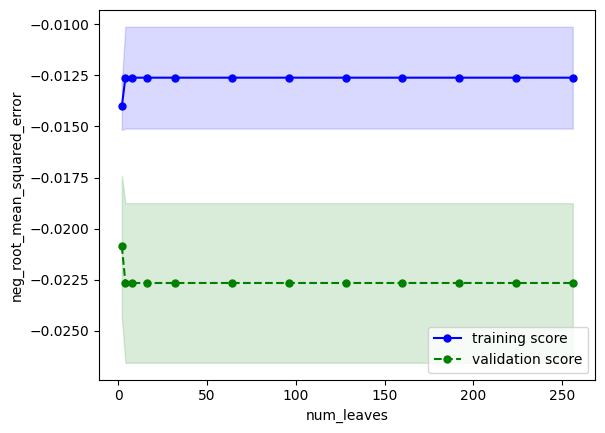

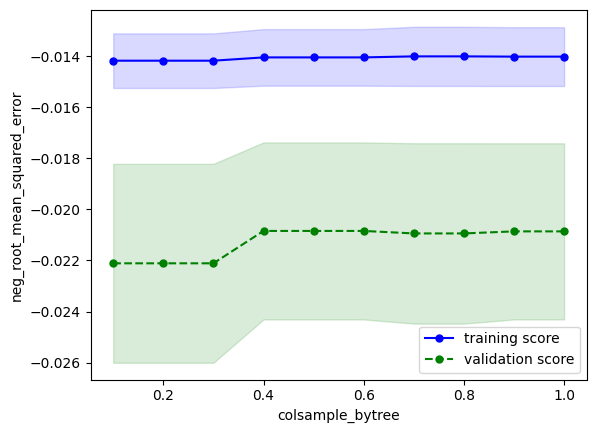

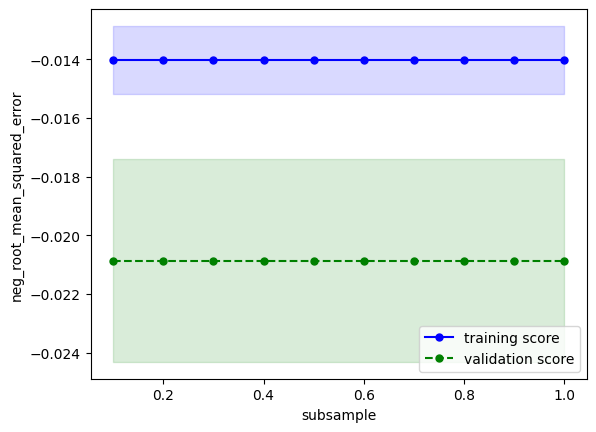

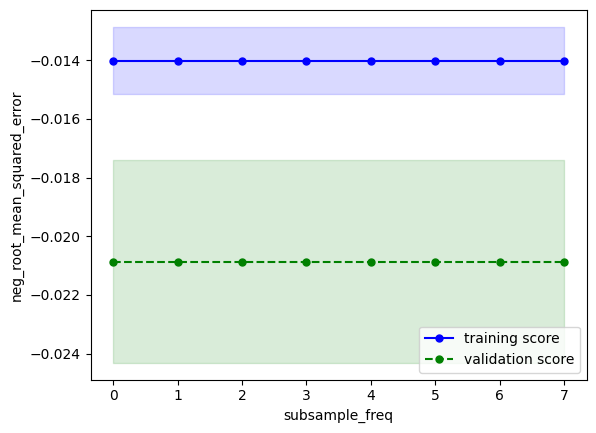

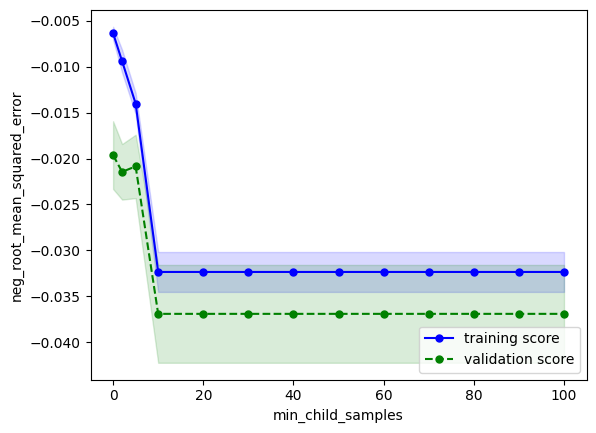

In [ ]:
from sklearn.model_selection import validation_curve
import matplotlib.pyplot as plt
model.set_params(min_child_samples=5, num_leaves=2)
# 検証曲線のプロット（パラメータ毎にプロット）
for i, (k, v) in enumerate(cv_params.items()):
    train_scores, valid_scores = validation_curve(estimator=model,
                                                  X=X, y=y,
                                                  param_name=k,
                                                  param_range=v,
                                                  fit_params=fit_params,
                                                  cv=cv, scoring=scoring,
                                                  n_jobs=-1)
    # 学習データに対するスコアの平均±標準偏差を算出
    train_mean = np.mean(train_scores, axis=1)
    train_std  = np.std(train_scores, axis=1)
    train_center = train_mean
    train_high = train_mean + train_std
    train_low = train_mean - train_std
    # テストデータに対するスコアの平均±標準偏差を算出
    valid_mean = np.mean(valid_scores, axis=1)
    valid_std  = np.std(valid_scores, axis=1)
    valid_center = valid_mean
    valid_high = valid_mean + valid_std
    valid_low = valid_mean - valid_std
    # training_scoresをプロット
    plt.plot(v, train_center, color='blue', marker='o', markersize=5, label='training score')
    plt.fill_between(v, train_high, train_low, alpha=0.15, color='blue')
    # validation_scoresをプロット
    plt.plot(v, valid_center, color='green', linestyle='--', marker='o', markersize=5, label='validation score')
    plt.fill_between(v, valid_high, valid_low, alpha=0.15, color='green')
    # スケールを'log'に（線形なパラメータは'linear'にするので注意）
    plt.xscale(param_scales[k])
    # 軸ラベルおよび凡例の指定
    plt.xlabel(k)  # パラメータ名を横軸ラベルに
    plt.ylabel(scoring)  # スコア名を縦軸ラベルに
    plt.legend(loc='lower right')  # 凡例
    # グラフを描画
    plt.show()

Other parameters have also changed.

The trend is not as pronounced as with SVM, but the tuning range is determined as follows based on the range where overfitting or underfitting does not occur.

#Parameter selection & cross-validation
As with SVM, we will explain each of the following four implementation methods: A, B, C (BayesianOptimization), and C (Optuna).

**A:grid search**

Round robin the parameters in a grid

Simple and highly interpretable

it takes a long time to calculate

Scikit-Learn

**B:Random Search**

Determine parameters randomly

Faster than grid search on average

There is an element of luck

Scikit-Learn

**C:Bayesian Optimization**

Determine parameters based on previous results

faster than random search

Somewhat difficult library operation

Bayesian Optimization, Optuna

In [ ]:
from sklearn.model_selection import GridSearchCV
start = time.time()
# 最終的なパラメータ範囲（1152通り）
cv_params = {'reg_alpha': [0.0001, 0.003, 0.1],
             'reg_lambda': [0.0001, 0.1],
             'num_leaves': [2, 3, 4, 6],
             'colsample_bytree': [0.4, 0.7, 1.0],
             'subsample': [0.4, 1.0],
             'subsample_freq': [0, 7],
             'min_child_samples': [0, 2, 5, 10]
             }
# グリッドサーチのインスタンス作成
gridcv = GridSearchCV(model, cv_params, cv=cv,
                      scoring=scoring, n_jobs=-1)
# グリッドサーチ実行（学習実行）
gridcv.fit(X, y, **fit_params)
# 最適パラメータの表示と保持
best_params = gridcv.best_params_
best_score = gridcv.best_score_
print(f'best_parameter {best_params}\n score {best_score}')
print(f'time: {time.time() - start}sec')

best_parameter {'colsample_bytree': 1.0, 'min_child_samples': 0, 'num_leaves': 2, 'reg_alpha': 0.003, 'reg_lambda': 0.0001, 'subsample': 0.4, 'subsample_freq': 0}
 score -0.019425366924400573
time: 41.17235088348389sec


In [ ]:
from sklearn.model_selection import RandomizedSearchCV
start = time.time()
# パラメータの種類と密度をグリッドサーチのときより増やす
cv_params = {'reg_alpha': [0.0001, 0.0003, 0.001, 0.003, 0.01, 0.03, 0.1],
             'reg_lambda': [0.0001, 0.0003, 0.001, 0.003, 0.01, 0.03, 0.1],
             'num_leaves': [2, 3, 4, 5, 6],
             'colsample_bytree': [0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0],
             'subsample': [0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0],
             'subsample_freq': [0, 1, 2, 3, 4, 5, 6, 7],
             'min_child_samples': [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10]
             }
# ランダムサーチのインスタンス作成
randcv = RandomizedSearchCV(model, cv_params, cv=cv,
                            scoring=scoring, random_state=seed,
                            n_iter=1120, n_jobs=-1)
# ランダムサーチ実行（学習実行）
randcv.fit(X, y, **fit_params)
# 最適パラメータの表示と保持
best_params = randcv.best_params_
best_score = randcv.best_score_
print(f'best_parameter {best_params}\n score {best_score}')
print(f'time: {time.time() - start}sec')

best_parameter {'subsample_freq': 4, 'subsample': 0.5, 'reg_lambda': 0.003, 'reg_alpha': 0.01, 'num_leaves': 4, 'min_child_samples': 0, 'colsample_bytree': 1.0}
 score -0.018200530696013854
time: 1425.9252662658691sec


Ramdam Search is 

In [ ]:
%pip install bayesian-optimization==1.4.1
from bayes_opt import BayesianOptimization
start = time.time()
# パラメータ範囲（Tupleで範囲選択）
bayes_params = {'reg_alpha': (0.0001, 0.1),
                'reg_lambda': (0.0001, 0.1),
                'num_leaves': (2, 6),
                'colsample_bytree': (0.4, 1.0),
                'subsample': (0.4, 1.0),
                'subsample_freq': (0, 7),
                'min_child_samples': (0, 10)
                }
# 対数スケールパラメータを対数化
param_scales = {'reg_alpha': 'log',
                'reg_lambda': 'log',
                'num_leaves': 'linear',
                'colsample_bytree': 'linear',
                'subsample': 'linear',
                'subsample_freq': 'linear',
                'min_child_samples': 'linear'
                }
bayes_params_log = {k: (np.log10(v[0]), np.log10(v[1])) if param_scales[k] == 'log' else v for k, v in bayes_params.items()}
# 整数型パラメータを指定
int_params = ['num_leaves', 'subsample_freq', 'min_child_samples']

# ベイズ最適化時の評価指標算出メソッド(引数が多いので**kwargsで一括読込)
def bayes_evaluate(**kwargs):
    params = kwargs
    # 対数スケールパラメータは10のべき乗をとる
    params = {k: np.power(10, v) if param_scales[k] == 'log' else v for k, v in params.items()}
    # 整数型パラメータを整数化
    params = {k: round(v) if k in int_params else v for k, v in params.items()}
    # モデルにパラメータ適用
    model.set_params(**params)
    # cross_val_scoreでクロスバリデーション
    scores = cross_val_score(model, X, y, cv=cv,
                             scoring=scoring, fit_params=fit_params, n_jobs=-1)
    val = scores.mean()
    return val

# ベイズ最適化を実行
bo = BayesianOptimization(bayes_evaluate, bayes_params_log, random_state=seed)
bo.maximize(init_points=20, n_iter=80, acq='ei')
# 最適パラメータとスコアを取得
best_params = bo.max['params']
best_score = bo.max['target']
# 対数スケールパラメータは10のべき乗をとる
best_params = {k: np.power(10, v) if param_scales[k] == 'log' else v for k, v in best_params.items()}
# 整数型パラメータを整数化
best_params = {k: round(v) if k in int_params else v for k, v in best_params.items()}
# 最適パラメータを表示
print(f'best_parameter {best_params}\n score {best_score}')
print(f'time: {time.time() - start}sec')

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Reason for being yanked: https://github.com/fmfn/BayesianOptimization/pull/388
|   iter    |  target   | colsam... | min_ch... | num_le... | reg_alpha | reg_la... | subsample | subsam... |
-------------------------------------------------------------------------------------------------------------
| 1         | -0.0369   | 0.6247    | 9.507     | 4.928     | -2.204    | -3.532    | 0.4936    | 0.4066    |
| 2         | -0.02105  | 0.9197    | 6.011     | 4.832     | -3.938    | -1.09     | 0.8995    | 1.486     |


<ipython-input-10-f0b638608400>:43: DeprecationWarning: 
Passing acquisition function parameters or gaussian process parameters to maximize
is no longer supported, and will cause an error in future releases. Instead,
please use the "set_gp_params" method to set the gp params, and pass an instance
 of bayes_opt.util.UtilityFunction using the acquisition_function argument

  bo.maximize(init_points=20, n_iter=80, acq='ei')


| 3         | -0.02139  | 0.5091    | 1.834     | 3.217     | -2.426    | -2.704    | 0.5747    | 4.283     |
| 4         | -0.02024  | 0.4837    | 2.921     | 3.465     | -2.632    | -1.644    | 0.5198    | 3.6       |
| 5         | -0.0252   | 0.7554    | 0.4645    | 4.43      | -3.488    | -3.805    | 0.9693    | 6.759     |
| 6         | -0.02066  | 0.885     | 3.046     | 2.391     | -1.947    | -2.68     | 0.4732    | 3.466     |
| 7         | -0.0369   | 0.4206    | 9.093     | 3.035     | -2.012    | -3.065    | 0.712     | 3.827     |
| 8         | -0.0369   | 0.5109    | 9.696     | 5.101     | -1.182    | -1.316    | 0.7587    | 6.453     |
| 9         | -0.01952  | 0.4531    | 1.96      | 2.181     | -3.024    | -2.834    | 0.5628    | 5.801     |
| 10        | -0.02101  | 0.6141    | 2.809     | 4.171     | -3.577    | -1.593    | 0.4447    | 6.908     |
| 11        | -0.02151  | 0.8633    | 1.987     | 2.022     | -1.554    | -1.879    | 0.8374    | 5.399     |
| 12      

In [ ]:
%pip install optuna
import optuna
start = time.time()
# ベイズ最適化時の評価指標算出メソッド
def bayes_objective(trial):
    params = {
        'reg_alpha': trial.suggest_float('reg_alpha', 0.0001, 0.1, log=True),
        'reg_lambda': trial.suggest_float('reg_lambda', 0.0001, 0.1, log=True),
        'num_leaves': trial.suggest_int('num_leaves', 2, 6),
        'colsample_bytree': trial.suggest_float('colsample_bytree', 0.4, 1.0),
        'subsample': trial.suggest_float('subsample', 0.4, 1.0),
        'subsample_freq': trial.suggest_int('subsample_freq', 0, 7),
        'min_child_samples': trial.suggest_int('min_child_samples', 0, 10)
    }
    # モデルにパラメータ適用
    model.set_params(**params)
    # cross_val_scoreでクロスバリデーション
    scores = cross_val_score(model, X, y, cv=cv,
                             scoring=scoring, fit_params=fit_params, n_jobs=-1)
    val = scores.mean()
    return val

# ベイズ最適化を実行
study = optuna.create_study(direction='maximize',
                            sampler=optuna.samplers.TPESampler(seed=seed))
study.optimize(bayes_objective, n_trials=400)

# 最適パラメータの表示と保持
best_params = study.best_trial.params
best_score = study.best_trial.value
print(f'best_parameter {best_params}\n score {best_score}')
print(f'time: {time.time() - start}sec')

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 365.7/365.7 kB 7.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 224.5/224.5 kB 17.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 78.7/78.7 kB 7.5 MB/s eta 0:00:00


[I 2023-05-19 01:47:29,927] A new study created in memory with name: no-name-745118ff-e506-4edd-bf58-d520fb89c95a
[I 2023-05-19 01:47:30,029] Trial 0 finished with value: -0.021169177296387797 and parameters: {'reg_alpha': 0.0013292918943162175, 'reg_lambda': 0.07114476009343425, 'num_leaves': 5, 'colsample_bytree': 0.759195090518222, 'subsample': 0.4936111842654619, 'subsample_freq': 1, 'min_child_samples': 0}. Best is trial 0 with value: -0.021169177296387797.
[I 2023-05-19 01:47:30,110] Trial 1 finished with value: -0.025027277783317047 and parameters: {'reg_alpha': 0.0396760507705299, 'reg_lambda': 0.006358358856676255, 'num_leaves': 5, 'colsample_bytree': 0.41235069657748147, 'subsample': 0.9819459112971965, 'subsample_freq': 6, 'min_child_samples': 2}. Best is trial 0 with value: -0.021169177296387797.
[I 2023-05-19 01:47:30,171] Trial 2 finished with value: -0.4885760357837275 and parameters: {'reg_alpha': 0.0003511356313970409, 'reg_lambda': 0.0003549878832196505, 'num_leaves':

best_parameter {'reg_alpha': 0.008768609750273266, 'reg_lambda': 0.01940783521995006, 'num_leaves': 2, 'colsample_bytree': 0.8255791738756124, 'subsample': 0.5458630791216087, 'subsample_freq': 3, 'min_child_samples': 0}
 score -0.01767777748408968
time: 87.1189923286438sec


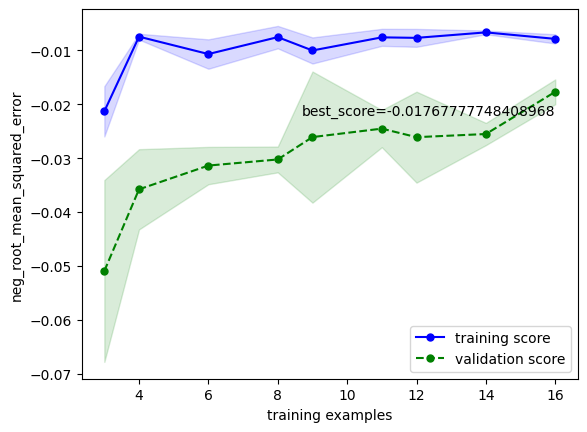

In [ ]:
from sklearn.model_selection import learning_curve
import matplotlib.pyplot as plt
# 最適パラメータを学習器にセット
model.set_params(**best_params)

# 学習曲線の取得
train_sizes, train_scores, valid_scores = learning_curve(estimator=model,
                                                         X=X, y=y,
                                                         train_sizes=np.linspace(0.1, 1.0, 10),
                                                         fit_params=fit_params,
                                                         cv=cv, scoring=scoring, n_jobs=-1)
# 学習データ指標の平均±標準偏差を計算
train_mean = np.mean(train_scores, axis=1)
train_std  = np.std(train_scores, axis=1)
train_center = train_mean
train_high = train_mean + train_std
train_low = train_mean - train_std
# 検証データ指標の平均±標準偏差を計算
valid_mean = np.mean(valid_scores, axis=1)
valid_std  = np.std(valid_scores, axis=1)
valid_center = valid_mean
valid_high = valid_mean + valid_std
valid_low = valid_mean - valid_std
# training_scoresをプロット
plt.plot(train_sizes, train_center, color='blue', marker='o', markersize=5, label='training score')
plt.fill_between(train_sizes, train_high, train_low, alpha=0.15, color='blue')
# validation_scoresをプロット
plt.plot(train_sizes, valid_center, color='green', linestyle='--', marker='o', markersize=5, label='validation score')
plt.fill_between(train_sizes, valid_high, valid_low, alpha=0.15, color='green')
# 最高スコアの表示
best_score = valid_center[len(valid_center) - 1]
plt.text(np.amax(train_sizes), valid_low[len(valid_low) - 1], f'best_score={best_score}',
                color='black', verticalalignment='top', horizontalalignment='right')
# 軸ラベルおよび凡例の指定
plt.xlabel('training examples')  # 学習サンプル数を横軸ラベルに
plt.ylabel(scoring)  # スコア名を縦軸ラベルに
plt.legend(loc='lower right')  # 凡例

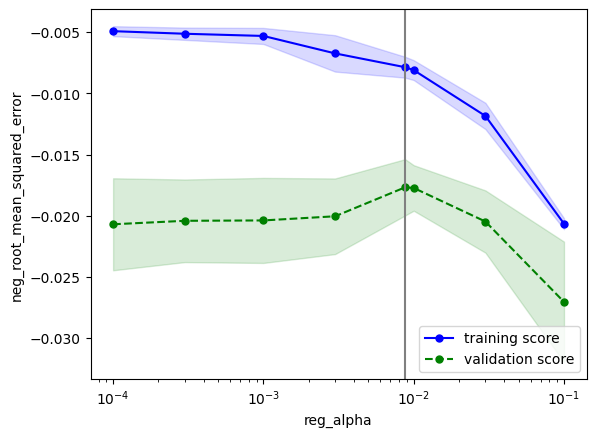

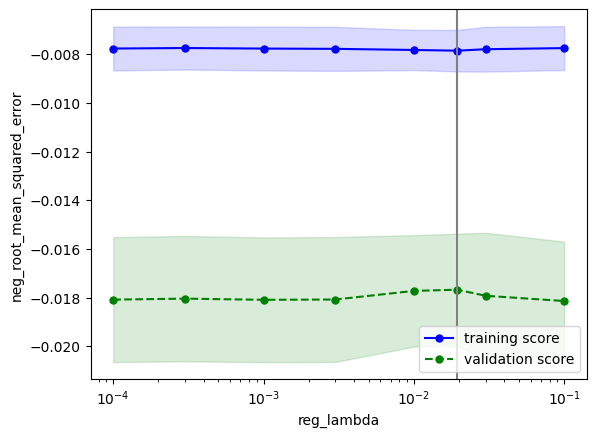

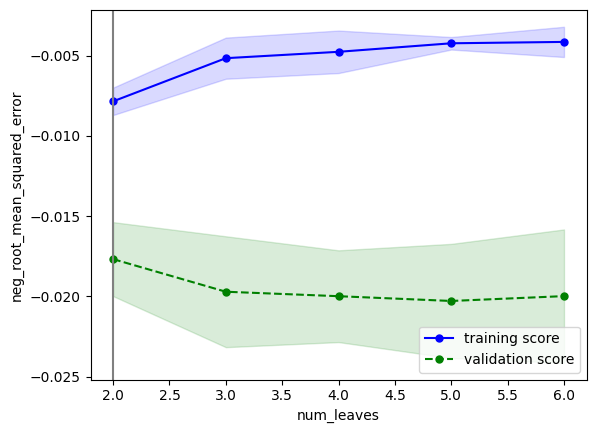

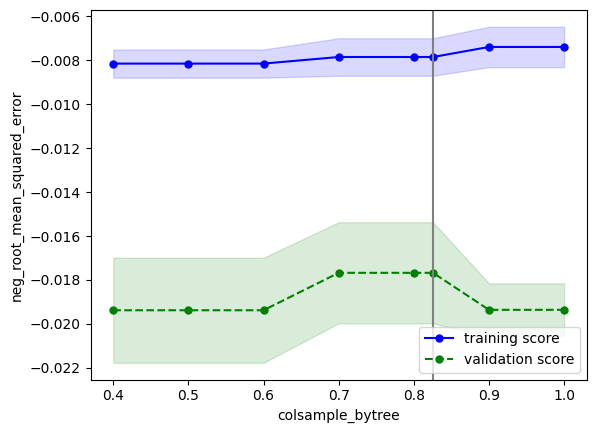

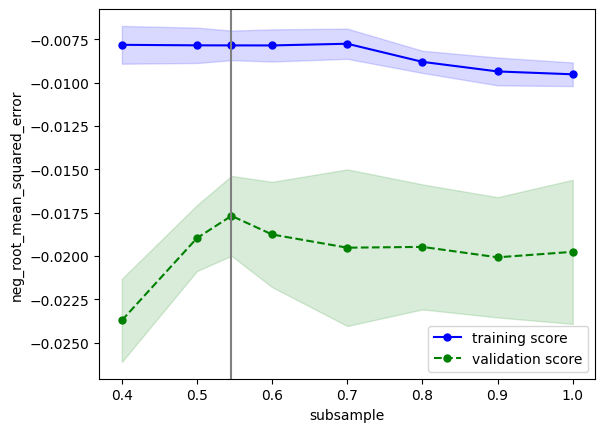

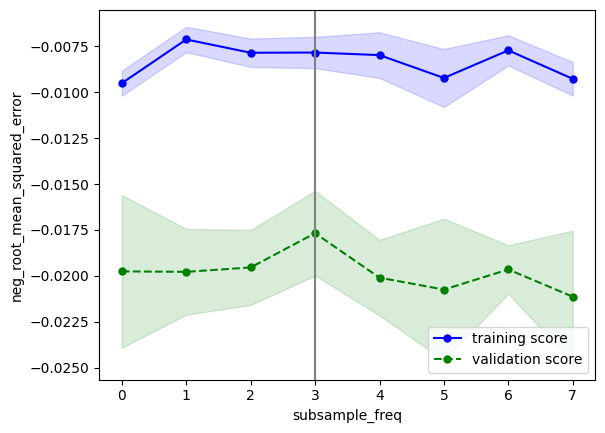

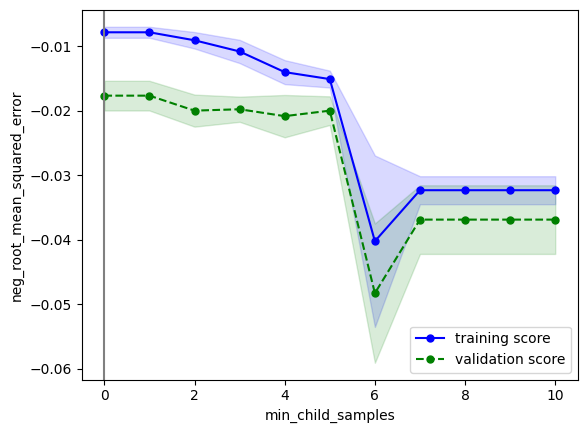

In [ ]:
from sklearn.model_selection import validation_curve
# 検証曲線描画対象パラメータ
valid_curve_params = {'reg_alpha': [0.0001, 0.0003, 0.001, 0.003, 0.01, 0.03, 0.1],
                      'reg_lambda': [0.0001, 0.0003, 0.001, 0.003, 0.01, 0.03, 0.1],
                      'num_leaves': [2, 3, 4, 5, 6],
                      'colsample_bytree': [0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0],
                      'subsample': [0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0],
                      'subsample_freq': [0, 1, 2, 3, 4, 5, 6, 7],
                      'min_child_samples': [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10]
                      }
param_scales = {'reg_alpha': 'log',
                'reg_lambda': 'log',
                'num_leaves': 'linear',
                'colsample_bytree': 'linear',
                'subsample': 'linear',
                'subsample_freq': 'linear',
                'min_child_samples': 'linear'
                }
# 最適パラメータを上記描画対象に追加
for k, v in valid_curve_params.items():
    if best_params[k] not in v:
        v.append(best_params[k])
        v.sort()
for i, (k, v) in enumerate(valid_curve_params.items()):
    # モデルに最適パラメータを適用
    model.set_params(**best_params)
    # 検証曲線を描画
    train_scores, valid_scores = validation_curve(estimator=model,
                                                  X=X, y=y,
                                                  param_name=k,
                                                  param_range=v,
                                                  fit_params=fit_params,
                                                  cv=cv, scoring=scoring,
                                                  n_jobs=-1)
    # 学習データに対するスコアの平均±標準偏差を算出
    train_mean = np.mean(train_scores, axis=1)
    train_std  = np.std(train_scores, axis=1)
    train_center = train_mean
    train_high = train_mean + train_std
    train_low = train_mean - train_std
    # テストデータに対するスコアの平均±標準偏差を算出
    valid_mean = np.mean(valid_scores, axis=1)
    valid_std  = np.std(valid_scores, axis=1)
    valid_center = valid_mean
    valid_high = valid_mean + valid_std
    valid_low = valid_mean - valid_std
    # training_scoresをプロット
    plt.plot(v, train_center, color='blue', marker='o', markersize=5, label='training score')
    plt.fill_between(v, train_high, train_low, alpha=0.15, color='blue')
    # validation_scoresをプロット
    plt.plot(v, valid_center, color='green', linestyle='--', marker='o', markersize=5, label='validation score')
    plt.fill_between(v, valid_high, valid_low, alpha=0.15, color='green')
    # 最適パラメータを縦線表示
    plt.axvline(x=best_params[k], color='gray')
    # スケールをparam_scalesに合わせて変更
    plt.xscale(param_scales[k])
    # 軸ラベルおよび凡例の指定
    plt.xlabel(k)  # パラメータ名を横軸ラベルに
    plt.ylabel(scoring)  # スコア名を縦軸ラベルに
    plt.legend(loc='lower right')  # 凡例
    # グラフを描画
    plt.show()

cv_number=0/3


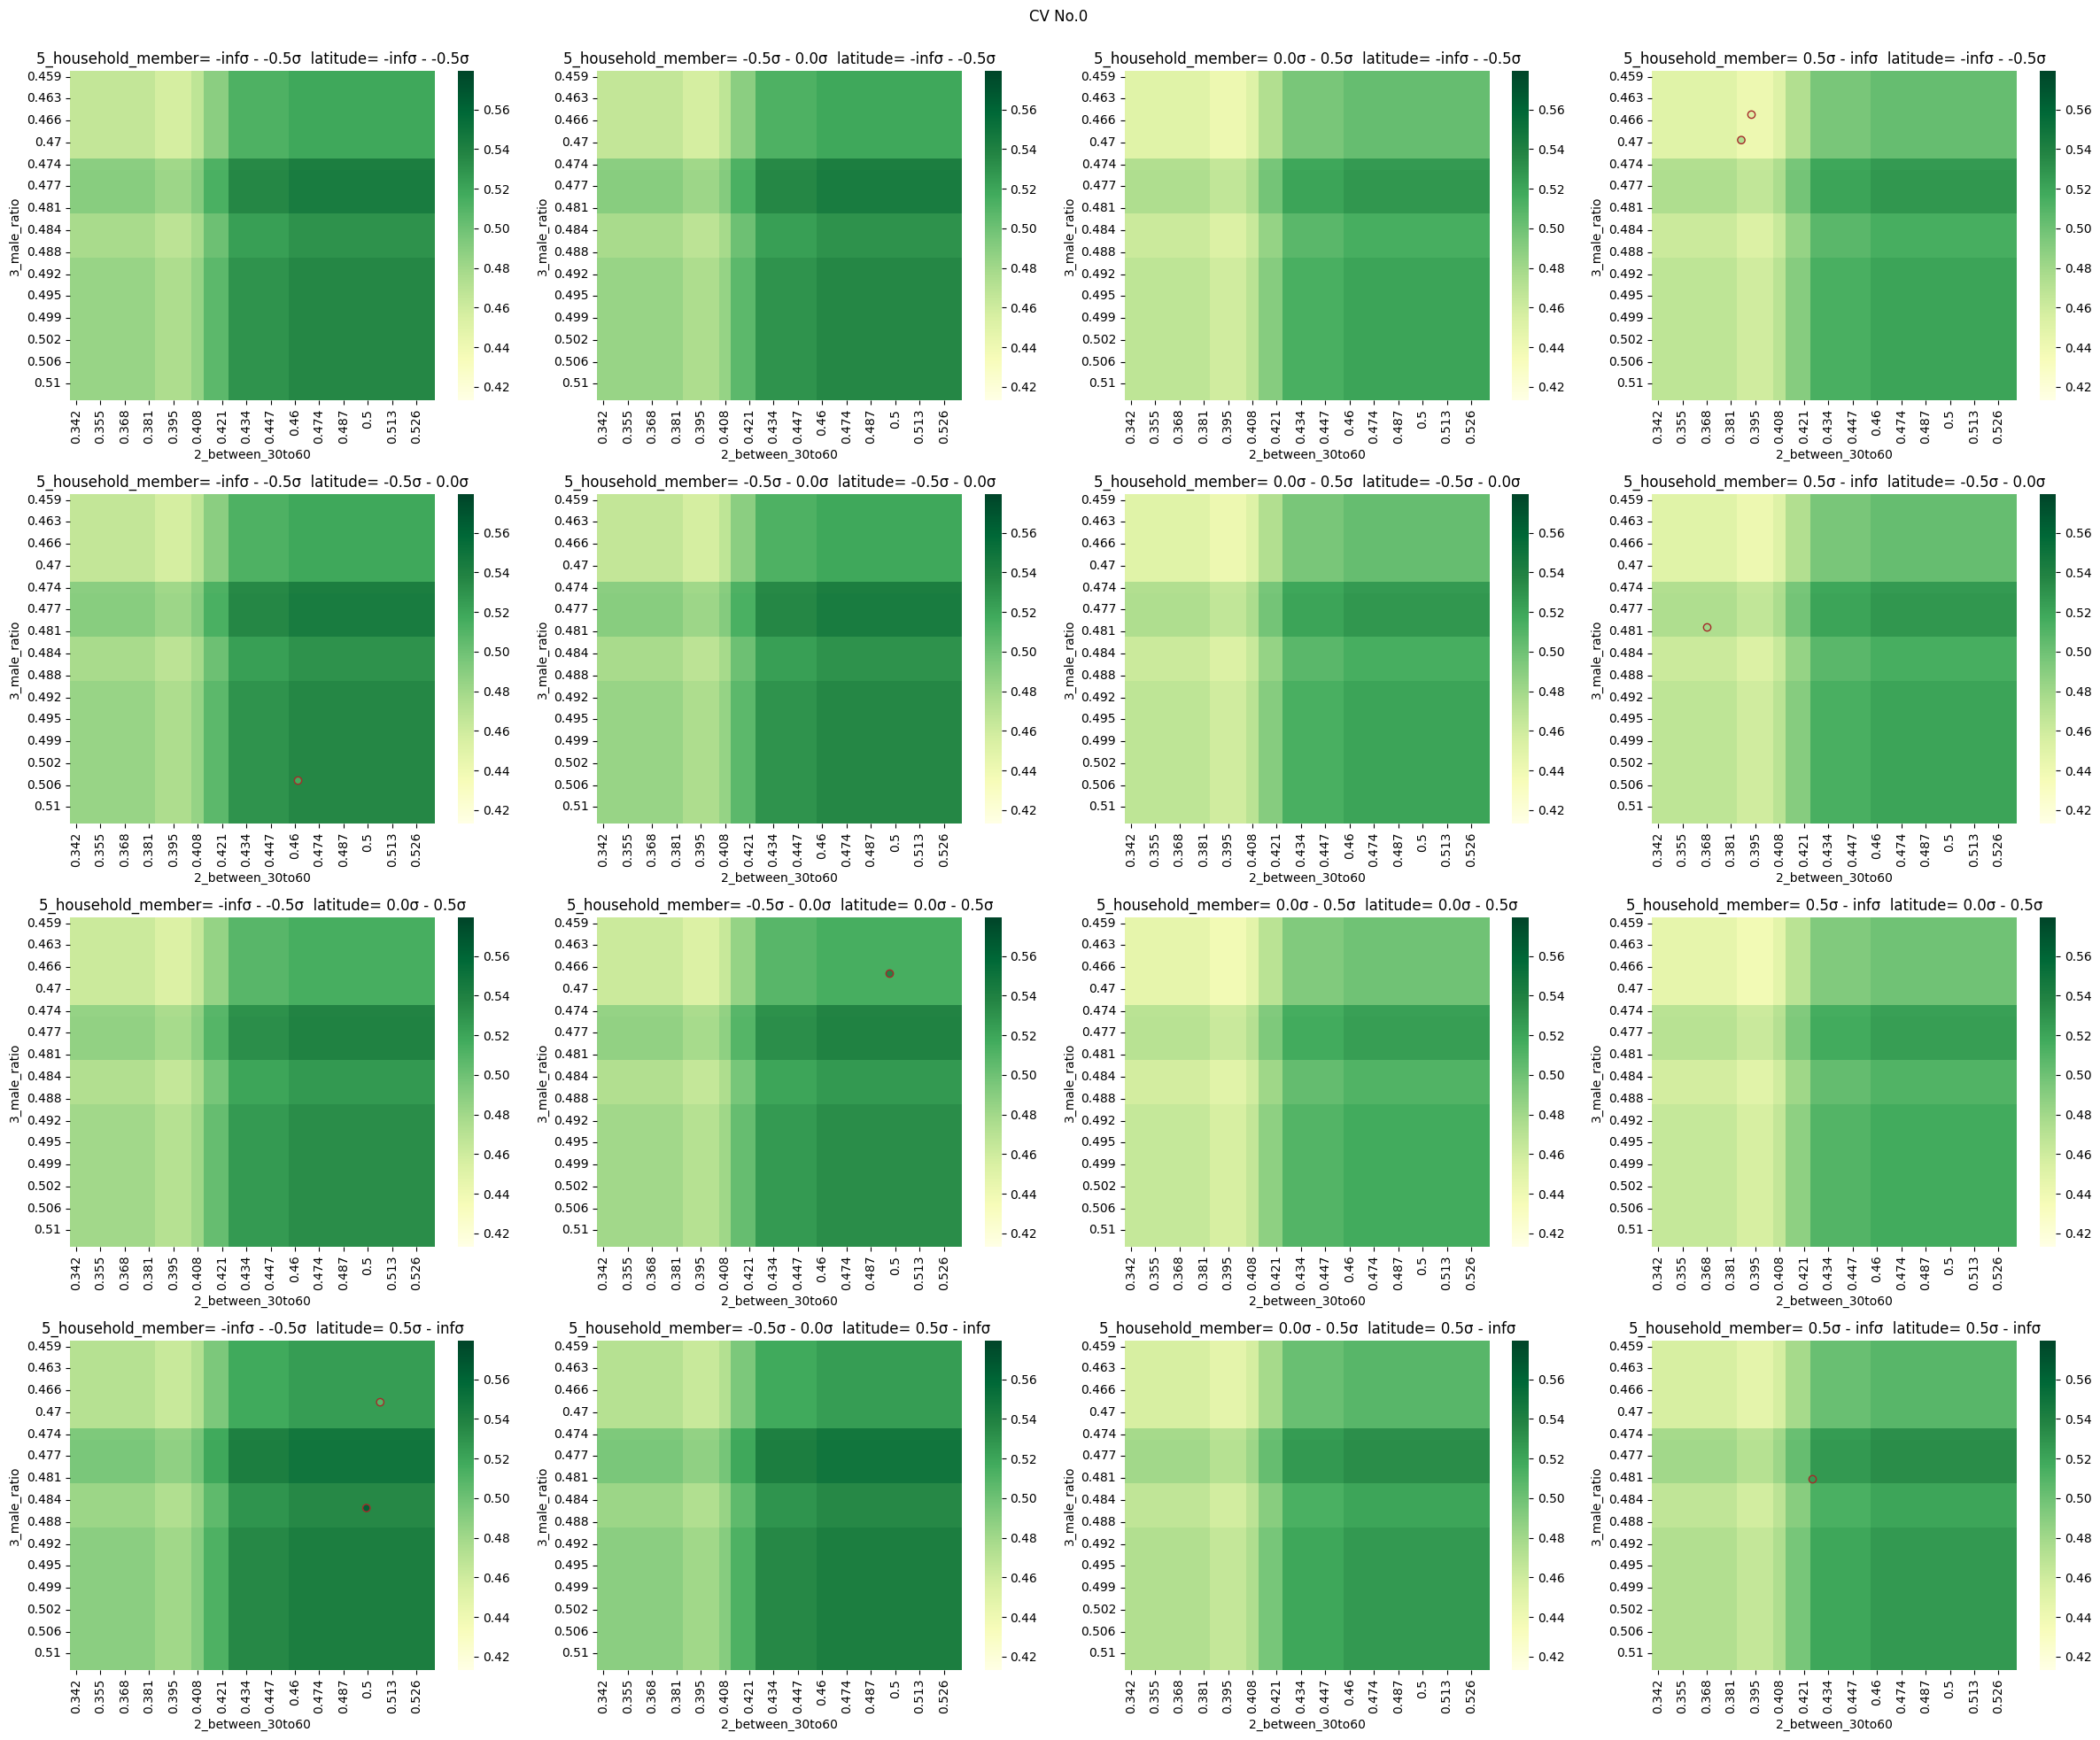

In [ ]:
regplot.regression_heat_plot(model, USE_EXPLANATORY, OBJECTIVE_VARIALBLE, df,
                             pair_sigmarange = 0.5, rounddigit_x1=3, rounddigit_x2=3,
                             cv=cv, display_cv_indices=0,
                             fit_params=fit_params, estimator_params=best_params)

Before tuning, the predictions were constant and did not regress well,

After tuning, the higher the male ratio (3_male_ratio),

 the more 30-60s (2_between_30to60), and the further north (latitude), 
 
 the higher the approval rate (approval_rate) = darker color, 
 
 indicating that the trend is captured.


Tuning Success


Parameter tuning of LightGBM was performed by selecting 7 parameters.

Optuna was the best algorithm among the four algorithms in terms of both speed and evaluation metrics.

Some of the parameters affect the learning time, so a wide range of parameters can slow down the speed of grid search.